In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy
from astropy.coordinates import SkyCoord, EarthLocation, AltAz

In [2]:
from nsb.core import PhotonMap, Frame
from nsb.scattering import atmosphere, instrument
from nsb.camera import iact
from nsb.emitter import moon, stars, airglow

# Predicting Night Sky Background for H.E.S.S.
The *nsb2* package was validated and tested first on the H.E.S.S. package. Here is full flow for implementing the commonly used Krisciunas Model for Moon&Airglow NSB, adding Stars from Tycho and Gaia and using the custom instrument transfer functions ffrom Cornils 2003. 

## 1. Configuring the model layers:

Configuring the models for emitters:

In [15]:
cachepath = '/home/gerritr/ECAP/nsb_simulation/nsb_data/'

conf_gaia  = {"cache_path": cachepath,
              "magmin" : 8,
              "magmax": 13,
              "cache": True}

conf_tycho = {"cache_path": cachepath,
             "magmin": -1.5,
             "magmax": 8.0,
             "cache": True}

conf_glow  = {"parameters": [52e10], "k": 0.179}

Configuring atmospheric scattering layers:

In [16]:
conf_KS1991 = {"parameters": [5.1276, 5.9596], "k": 0.079}
conf_King71 = {"parameters": [3.33e9, 1.14, np.deg2rad(0.000278)], "k": 0.279}

Configuring telescope scattering layer (for CT1):

In [17]:
conf_Cornils = {"parameters": [0.1, np.deg2rad(2.5)]}

## 2. Creating the pipeline:
### Simple Model (w/o Pointing, Flatfielding, UBV)

In [19]:
# Load all emitters
## Star Catalog from Tycho
tycho = stars.Tycho([], conf_tycho)
## Star Catalog from Gaia
gaia = stars.GaiaDR3([], conf_gaia)
## Moon from Krisciunas
kris = moon.KS1991([])
## Air Glow from Krisciunas
glow = airglow.KS1991([], conf_glow)

# Atmospheric Propagations
## Photon Map for moonlight using KS1991
atm_moon = PhotonMap([atmosphere.KS1991([kris], conf_KS1991)], np.deg2rad(180))

## Atmospheric Scattering for Stars from King1971 for bright Tycho stars
atm_stars = atmosphere.King1971([tycho], 
                                 conf_King71,
                                 N_sample=10)

# HESS1 telescope scattering function from Cornils et al. 2003 for Tycho & Moon
cornils_hb = instrument.Cornils2003([atm_moon, glow, tycho],
                                     conf_Cornils, 
                                     N_sample=100)

# Photon Map over Telescope for low brightness Gaia stars:
cornils_lb = PhotonMap([instrument.Cornils2003([gaia], conf_Cornils)], np.deg2rad(0.3))

# HESS1U era camera geometry
pipe = iact.FlashCam([cornils_hb, cornils_lb], N_sample=4)

Achieved max Mag lower than expected 13.20 < 13.2
/home/gerritr/.cache/ctapipe/cccta-dataserver.in2p3.fr/data/ctapipe-extra/v0.3.4 FlashCam.camgeom.fits.gz False
/home/gerritr/.cache/ctapipe/cccta-dataserver.in2p3.fr/data/ctapipe-extra/v0.3.4 FlashCam.camgeom.fits False
/home/gerritr/.cache/ctapipe/cccta-dataserver.in2p3.fr/data/ctapipe-extra/v0.3.4 FlashCam.camgeom.ecsv False
/home/gerritr/.cache/ctapipe/cccta-dataserver.in2p3.fr/data/ctapipe-extra/v0.3.4 FlashCam.camgeom.ecsv.txt False


### Visualizing the pipeline

## 3. Determining a frame to capture:
A "frame" describing a capture is determined by:
 - A location
 - An observation time in UTC
 - A target at which to point

In [20]:
location = EarthLocation.from_geodetic(16.5028, -23.27280, 1800.)
obstime  = astropy.time.Time('2023-05-15T01:27:44', format='isot', scale='utc')
target   = SkyCoord(dec = "1°48'0", ra = "18h56m7s", frame='icrs', obstime=obstime)
fov      = 3.5

frame = Frame(location, obstime, target, fov)

## 4. Running the pipeline:
Calling the pipeline on a frame is very easy then:

In [21]:
%%time
res = pipe(frame)

CPU times: user 38.7 s, sys: 2.95 s, total: 41.7 s
Wall time: 41.7 s


## 5. Visualizing the data:
Each pipeline layer has it's corresponding visualization. It can either be called on a frame or rays generated by the same layer. As such, the final data can be easily evaluated:

### All data combined

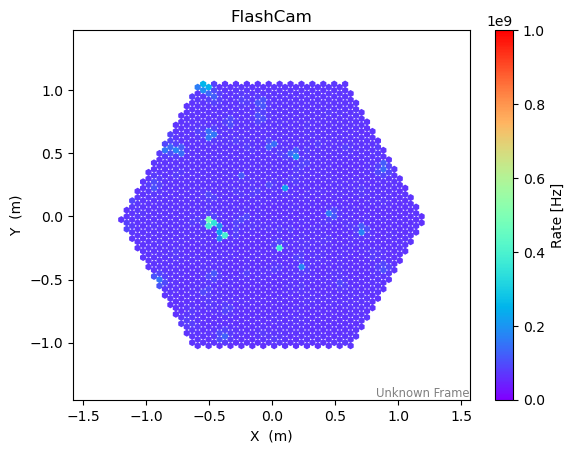

In [27]:
fig, ax = plt.subplots() 
disp = pipe.display(res, ax, 'Rate [Hz]')
disp.cmap = 'rainbow'
disp.set_limits_minmax(0, 1e9)

### Individual contributions
Filtering by source type, we can also look at the individual contributions to each pixel by each source:

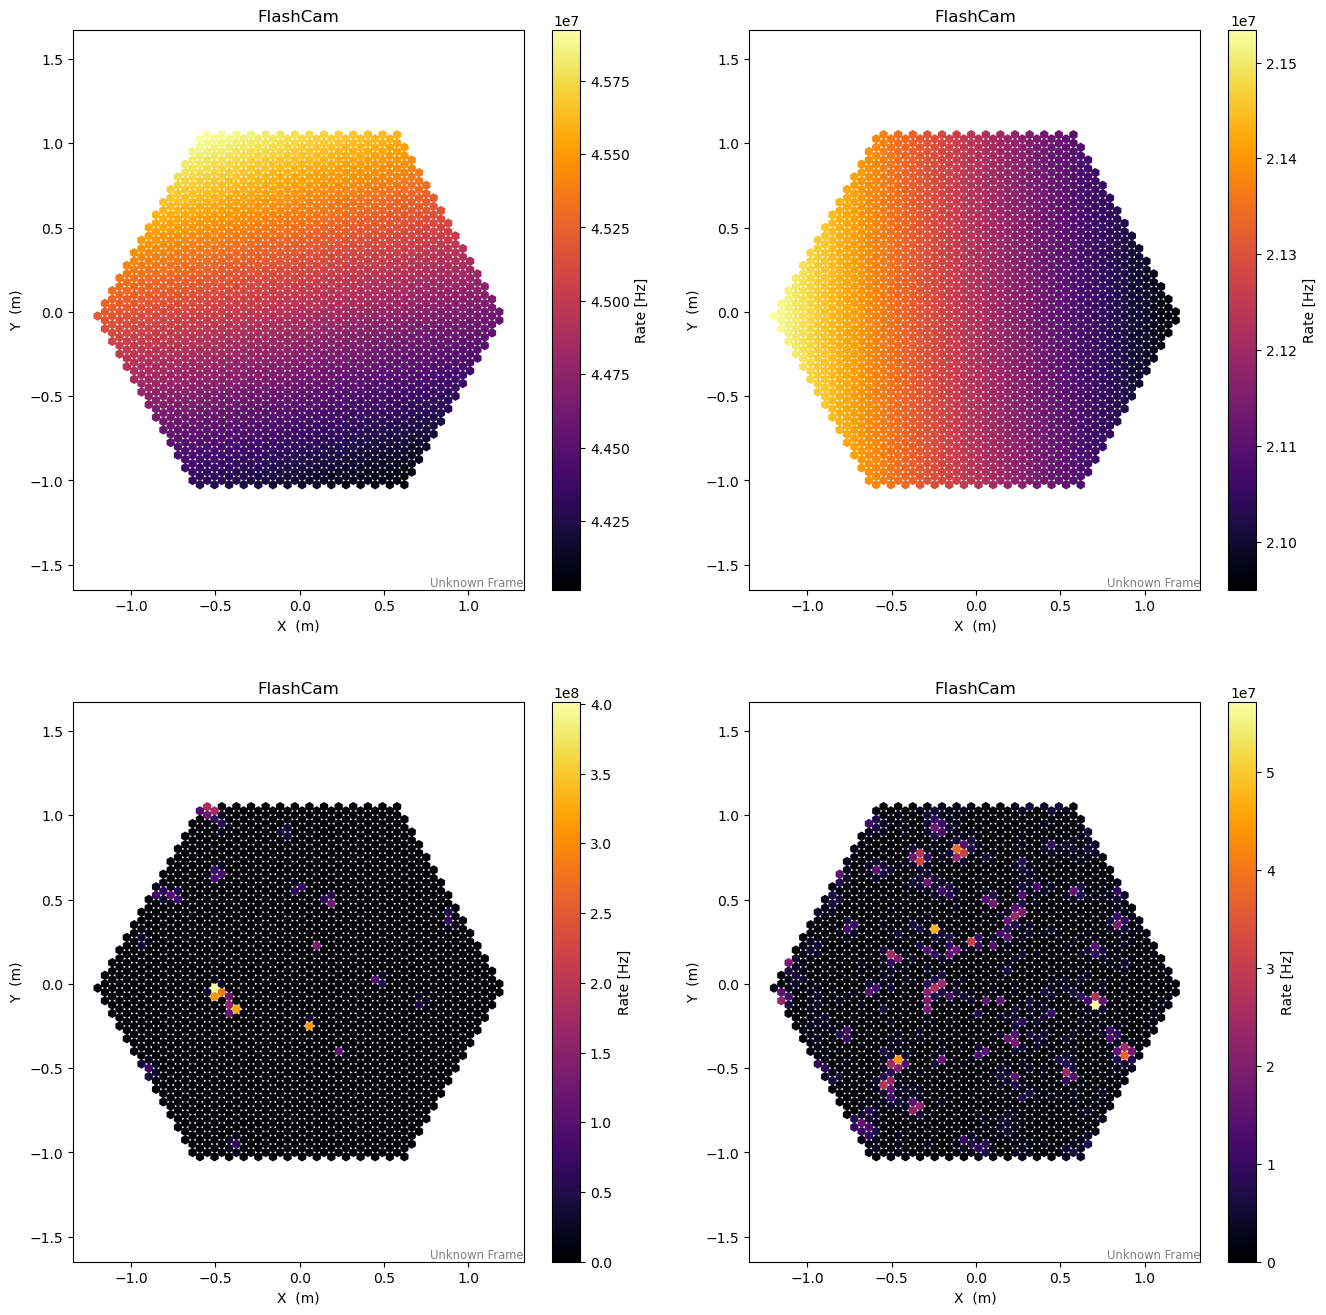

In [25]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,16))
disp1 = pipe.display(res[res.source == type(kris)], ax[0,0], 'Rate [Hz]')
disp2 = pipe.display(res[res.source == type(glow)], ax[0,1], 'Rate [Hz]')
disp3 = pipe.display(res[res.source == type(tycho)], ax[1,0], 'Rate [Hz]')
disp4 = pipe.display(res[res.source == type(gaia)], ax[1,1], 'Rate [Hz]')